In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

In [2]:
max_sequence_length = 10
d_model = 6

Let’s dive straight into this. Suppose you have an input sequence of length L and require $k^{th}$ object within this sequence. The positional encoding is given by sine and cosine functions of varying frequencies:


$$P(k, 2i) = sin(\frac{k}{n^{\frac{2i}{d}}})$$
$$P(k, 2i+1) = cos(\frac{k}{n^{\frac{2i}{d}}})$$


Here,

$k$: Position of an object in the input sequence, $0\le k  < L/2$

$d$: : Dimension of the output embedding space

$P(k, j)$: Position function for mapping a position $k$ in the input sequence to index $(k, j)$ of the positional matrix.

$n$: User-defined scalar, set to $10,000$ by the authors of Attention Is All You Need.

$i$: Used for mapping to column indices $0 \le i < d/2 $  with a single value of $i$ maps to both sine and cosine functions

In the above expression, you can see that even positions correspond to a sine function and odd positions correspond to cosine functions.


Based on our codebase, we can write even function and odd function as below

$$PE(position, 2i) = sin(\frac{position}{10000^{\frac{2i}{d_model}}})$$
$$PE(position, 2i + 1) = cos(\frac{position}{10000^{\frac{2i}{d_model}}})$$


We can rewrite these as.
$$
PE(position, i) =
\begin{cases}
    \sin\left(\frac{position}{10000^{\frac{i}{d_{\text{model}}}}}\right) & \text{when } i \text{ is even} \\ \\
    \cos\left(\frac{position}{10000^{\frac{i-1}{d_{\text{model}}}}}\right) & \text{when } i \text{ is odd}
\end{cases}
$$

In [3]:
even_i = torch.arange(0, d_model, 2).float()
even_i

tensor([0., 2., 4.])

In [4]:
even_denominator = torch.pow(10000, even_i/d_model)
even_denominator

tensor([  1.0000,  21.5443, 464.1590])

In [5]:
odd_i = torch.arange(1, d_model, 2).float()
odd_i

tensor([1., 3., 5.])

In [6]:
old_denominator = torch.pow(10000, (odd_i - 1)/d_model)
old_denominator

tensor([  1.0000,  21.5443, 464.1590])

## `Even Denominator` and `odd Denominator` are the same! So we can just do one of these actions and call the resulting variable denominator

In [7]:
denominator = even_denominator

In [8]:
position = torch.arange(max_sequence_length, dtype=torch.float).reshape(max_sequence_length, 1)

In [9]:
even_PE = torch.sin(position / denominator)
odd_PE = torch.cos(position / denominator)

In [10]:
even_PE.shape

torch.Size([10, 3])

In [11]:
odd_PE.shape

torch.Size([10, 3])

In [12]:
stacked = torch.stack([even_PE, odd_PE], dim=2)
stacked.shape

torch.Size([10, 3, 2])

In [13]:
PE = torch.flatten(stacked, start_dim=1, end_dim=2)
PE

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000],
        [-0.7568, -0.6536,  0.1846,  0.9828,  0.0086,  1.0000],
        [-0.9589,  0.2837,  0.2300,  0.9732,  0.0108,  0.9999],
        [-0.2794,  0.9602,  0.2749,  0.9615,  0.0129,  0.9999],
        [ 0.6570,  0.7539,  0.3192,  0.9477,  0.0151,  0.9999],
        [ 0.9894, -0.1455,  0.3629,  0.9318,  0.0172,  0.9999],
        [ 0.4121, -0.9111,  0.4057,  0.9140,  0.0194,  0.9998]])

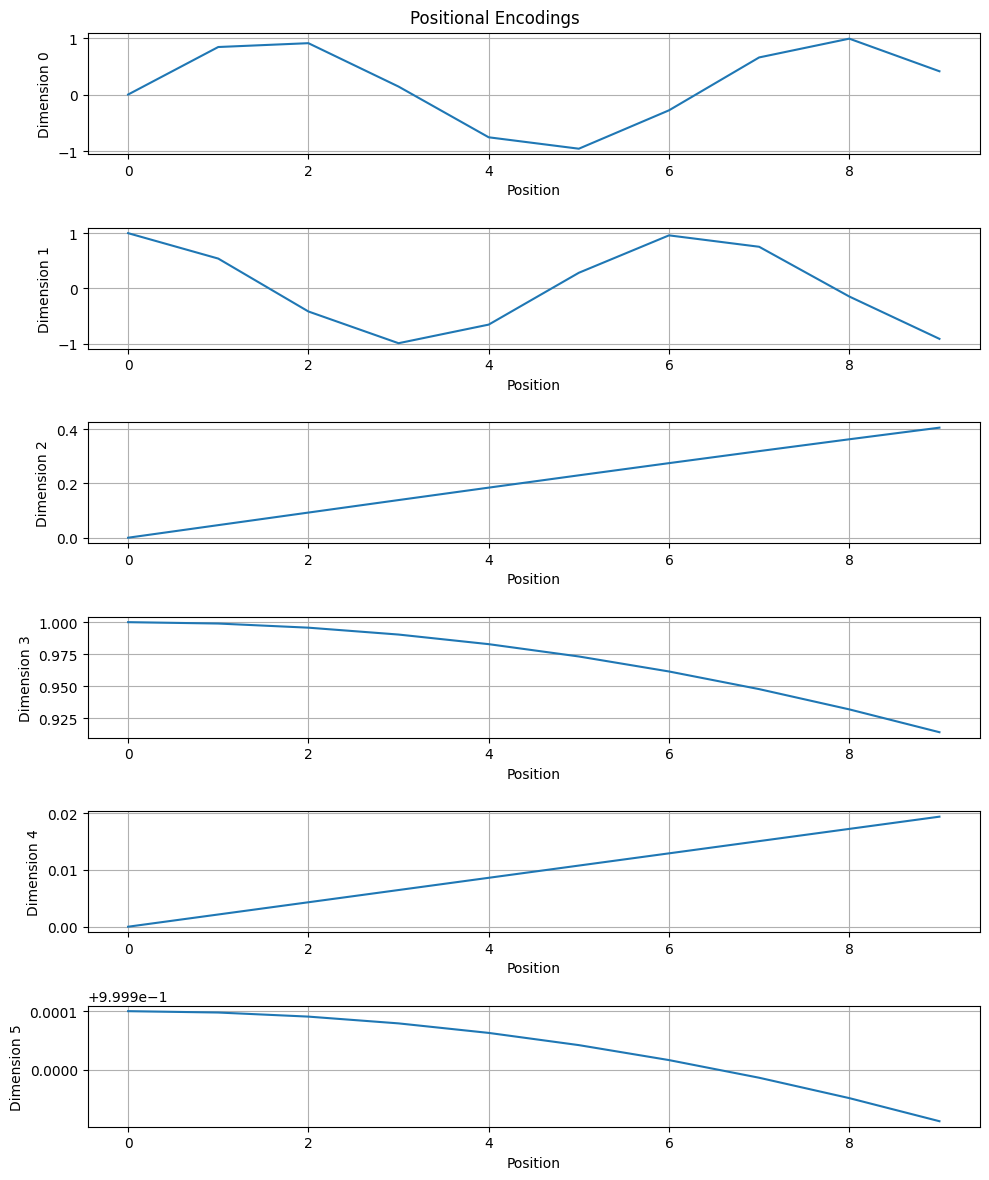

In [14]:
num_dimensions = PE.shape[1]
fig, axs = plt.subplots(num_dimensions, figsize=(10, 2*num_dimensions))
fig.suptitle('Positional Encodings')

# Plot each dimension's encoding
for dim in range(num_dimensions):
    axs[dim].plot(PE[:, dim].numpy())
    axs[dim].set(xlabel='Position', ylabel=f'Dimension {dim}')
    axs[dim].grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [15]:
class PositionEmbeddingLayer(nn.Module):
    def __init__(self, sequence_length, vocab_size, output_dim):
        super(PositionEmbeddingLayer, self).__init__()
        self.word_embedding_layer = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=output_dim
        )
        self.position_embedding_layer = nn.Embedding(
            num_embeddings=sequence_length, embedding_dim=output_dim
        )

    def forward(self, inputs):
        position_indices = torch.arange(inputs.size(-1))
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_words + embedded_indices

In [16]:
class PositionEmbeddingFixedWeights(nn.Module):
  def __init__(self, vocab_size, output_dim, sequence_length, d_model):
    super().__init__()
    self.sequence_length = sequence_length
    self.d_model = d_model

    # Create the position embedding matrix
    self.position_embedding_matrix = self.get_position_encoding(sequence_length, output_dim)

    # Define the word embedding layer
    self.word_embedding_layer = nn.Embedding(vocab_size, output_dim)

  def get_position_encoding(self, seq_len, d_model):
        even_i = torch.arange(0, d_model, 2).float()
        denominator = torch.pow(10000, even_i / d_model)
        position = torch.arange(seq_len).reshape(seq_len, 1)
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)
        stacked = torch.stack([even_PE, odd_PE], dim=2)
        PE = torch.flatten(stacked, start_dim=1, end_dim=2)
        return PE

  def forward(self, inputs):
        position_indices = torch.arange(self.sequence_length)
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_matrix[position_indices]
        return embedded_words + embedded_indices

In [17]:
# Example usage
vocab_size = 10000
output_dim = 128
sequence_length = 100
d_model = 128
batch_size = 16

# Create an instance of PositionalEncoding
positional_encoding = PositionEmbeddingFixedWeights(vocab_size, output_dim, sequence_length, d_model)

# Generate a random input tensor
inputs = torch.randint(0, vocab_size, (batch_size, sequence_length))

# Apply positional encoding
encoded_inputs = positional_encoding(inputs)

print(encoded_inputs.shape)

torch.Size([16, 100, 128])


In [18]:
class TextVectorizer(nn.Module):
    def __init__(self, vocab_size, output_seq_len):
        super(TextVectorizer, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, output_seq_len, sparse=True)
        self.vocab_size = vocab_size

    def forward(self, text):
        return self.embedding(text)

technical_phrase = "to understand machine learning algorithms you need" +\
                   " to understand concepts such as gradient of a function "+\
                   "Hessians of a matrix and optimization etc"
wise_phrase = "patrick henry said give me liberty or give me death "+\
              "when he addressed the second virginia convention in march"

# Split the phrases into words and create a vocabulary
all_words = (technical_phrase + " " + wise_phrase).split()
word_to_index = {word: index for index, word in enumerate(set(all_words))}
index_to_word = {index: word for word, index in word_to_index.items()}

# Convert phrases to sequences of word indices
technical_seq = [word_to_index[word] for word in technical_phrase.split()]
wise_seq = [word_to_index[word] for word in wise_phrase.split()]

# Pad sequences to a fixed length
sequence_length = 20
technical_seq = torch.tensor(technical_seq[:sequence_length])
wise_seq = torch.tensor(wise_seq[:sequence_length])

# Pad sequences to the same length
padded_technical_seq = nn.functional.pad(technical_seq, (0, sequence_length - len(technical_seq)))
padded_wise_seq = nn.functional.pad(wise_seq, (0, sequence_length - len(wise_seq)))

# Create a batch of sequences
phrase_tensors = torch.stack([padded_technical_seq, padded_wise_seq])

# Create the TextVectorizer
total_vocab_size = len(word_to_index)
vectorization_layer = TextVectorizer(total_vocab_size, sequence_length)

# Get vectorized phrases
vectorized_phrases = vectorization_layer(phrase_tensors)
vectorized_phrases = vectorized_phrases.long()
print(vectorized_phrases)

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [19]:
total_vocabulary = 200
sequence_length = 20
final_output_len = 50
d_model = 128

random_weights_embedding_layer = PositionEmbeddingLayer(sequence_length,
                                                        total_vocabulary,
                                                        final_output_len)

fixed_weights_embedding_layer = PositionEmbeddingFixedWeights(
    total_vocabulary, final_output_len, sequence_length, d_model)

random_embedding = random_weights_embedding_layer(vectorized_phrases)
fixed_embedding = fixed_weights_embedding_layer(vectorized_phrases)

In [20]:
fixed_embedding

tensor([[[-0.3509,  1.3174,  0.6466,  ...,  1.8508,  0.9245,  1.2391],
         [ 0.4906,  0.8577,  1.2845,  ...,  1.8508,  0.9246,  1.2391],
         [ 0.5584, -0.0987,  1.6291,  ...,  1.8508,  0.9248,  1.2391],
         ...,
         [-1.3123,  0.0423, -0.0744,  ...,  1.8508,  0.9270,  1.2391],
         [-1.1019,  0.9777,  0.5334,  ...,  1.8508,  0.9271,  1.2391],
         [-0.2010,  1.3061,  1.1933,  ...,  1.8508,  0.9272,  1.2391]],

        [[-0.3509,  1.3174,  0.6466,  ...,  1.8508,  0.9245,  1.2391],
         [ 0.4906,  0.8577,  1.2845,  ...,  1.8508,  0.9246,  1.2391],
         [ 0.5584, -0.0987,  1.6291,  ...,  1.8508,  0.9248,  1.2391],
         ...,
         [-1.3123,  0.0423, -0.0744,  ...,  1.8508,  0.9270,  1.2391],
         [-1.1019,  0.9777,  0.5334,  ...,  1.8508,  0.9271,  1.2391],
         [-0.2010,  1.3061,  1.1933,  ...,  1.8508,  0.9272,  1.2391]]],
       grad_fn=<AddBackward0>)

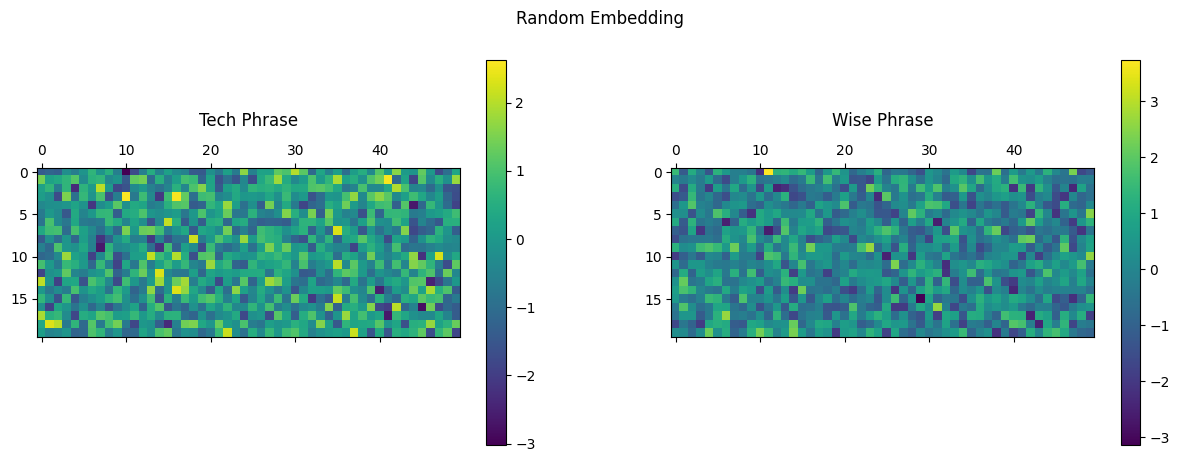

In [21]:
import matplotlib.pyplot as plt

random_embedding = torch.randn(2, sequence_length, final_output_len)

fig = plt.figure(figsize=(15, 5))
title = ["Tech Phrase", "Wise Phrase"]
for i in range(2):
    ax = plt.subplot(1, 2, 1+i)
    matrix = random_embedding[i, :, :].reshape(sequence_length, final_output_len).numpy()
    cax = ax.matshow(matrix)
    plt.gcf().colorbar(cax)
    plt.title(title[i], y=1.2)
fig.suptitle("Random Embedding")
plt.show()

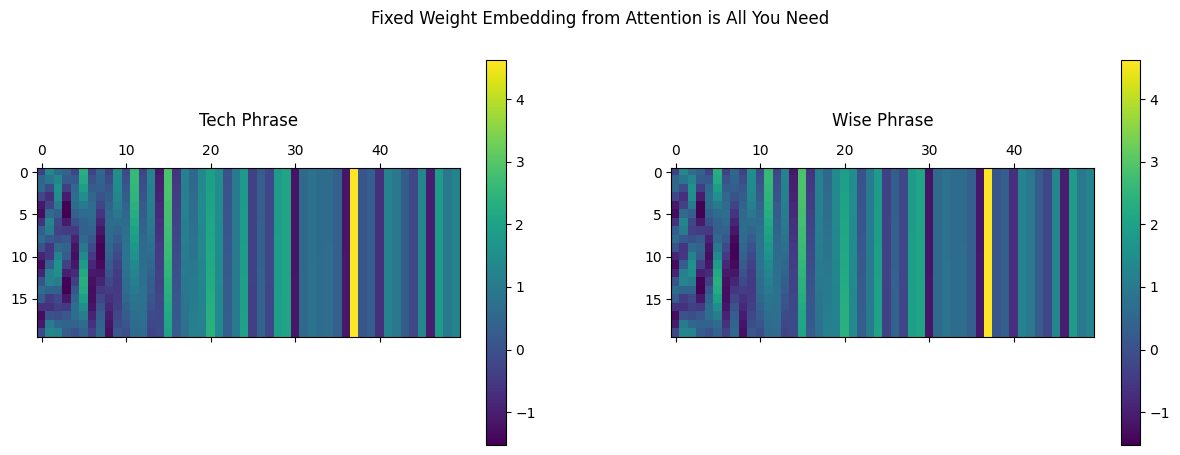

In [22]:
import torch
import matplotlib.pyplot as plt

# Assuming fixed_embedding is a PyTorch tensor with shape (2, sequence_length, final_output_len)

fig = plt.figure(figsize=(15, 5))
title = ["Tech Phrase", "Wise Phrase"]

for i in range(2):
    ax = plt.subplot(1, 2, 1+i)
    matrix = fixed_embedding[i, :, :]
    cax = ax.matshow(matrix.detach().numpy())  # Convert tensor to numpy array for visualization
    plt.colorbar(cax)
    plt.title(title[i], y=1.2)

fig.suptitle("Fixed Weight Embedding from Attention is All You Need")
plt.show()